# ESC-50 EDA: 生音→周波数→スペクトログラム→Log-Mel（モデル特徴）まで上流から徹底可視化

このノートは **「モデル前の表現レベル」**で ESC-50 を観察し、  
- 波形（時間領域）
- 周波数スペクトル（FFT）
- スペクトログラム（STFT）
- Log-Mel（本プロジェクトの特徴量）

を **ラベル（category）ごとに比較**するための EDA（探索的データ解析）ノートです。

---

## 研究者っぽい運用の思想
- 学習（CLI）コードは壊さない／触らない
- Notebook は探索・仮説・可視化に集中
- 後で再利用したくなったら Notebook 内の関数を `src/eda/` に昇格（ライブラリ化）
- 解析の入出力は `reports/<run_id>/eda/` に保存して “実験資産化”


## 0. 依存パッケージ
基本はプロジェクト依存（numpy/pandas/torch/(torchaudio or soundfile)/matplotlib）で動くようにしています。

追加で入れると便利：
```bash
pip install soundfile
```
※ torchaudio が環境依存で壊れやすい場合、soundfile 推奨（あなたの環境の事情に合わせる）。


In [1]:
from __future__ import annotations

import sys
import os
from pathlib import Path
import math
import random
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 6)

# optional audio backend
HAS_SF = True
try:
    import soundfile as sf
except Exception:
    HAS_SF = False

print("torch:", torch.__version__)
print("cuda available:", torch.cuda.is_available())
print("soundfile available:", HAS_SF)


torch: 2.9.1+cu128
cuda available: True
soundfile available: True


## 1. プロジェクトルートを特定し `src` を import できるようにする

理想は `pip install -e .`（editable install）ですが、Notebook 実行場所がブレても動くようにフォールバックを入れます。


In [2]:
def find_project_root(start: Path | None = None) -> Path:
    start = start or Path.cwd()
    cur = start.resolve()
    for _ in range(8):
        if (cur / "src").exists() and (cur / "config").exists():
            return cur
        if cur.parent == cur:
            break
        cur = cur.parent
    raise RuntimeError("Project root not found. Open notebook under project directory.")

ROOT = find_project_root()
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

print("Project root:", ROOT)


Project root: C:\Users\hirok\code\02_sound\esc50_cnn


In [3]:
# Project imports
from src.utils.config import load_yaml
from src.data.metadata import load_esc50_metadata
from src.data.features import FeatureConfig, LogMelExtractor

print("Imported project modules successfully")


Imported project modules successfully


## 2. config / paths / metadata をロード（ルート基準で安全に解決）

Notebook の cwd に依存しないように、config の相対パスは必ず ROOT に結合して絶対パス化します。


In [4]:
def resolve_path(p: str | Path, root: Path) -> Path:
    p = Path(p)
    return p if p.is_absolute() else (root / p).resolve()

CFG_PATH = ROOT / "config" / "default.yaml"
cfg = load_yaml(CFG_PATH)

paths = cfg.get("paths", {})
meta_csv = resolve_path(paths.get("meta_csv", "data/meta/esc50.csv"), ROOT)
audio_dir = resolve_path(paths.get("audio_dir", "data/audio"), ROOT)

df = load_esc50_metadata(meta_csv)
print("meta_csv:", meta_csv)
print("audio_dir:", audio_dir)
print("rows:", len(df), "classes:", df["target"].nunique())
df.head()


meta_csv: C:\Users\hirok\code\02_sound\esc50_cnn\data\meta\esc50.csv
audio_dir: C:\Users\hirok\code\02_sound\esc50_cnn\data\audio
rows: 2000 classes: 50


filename  fold  target        category  esc10  src_file take
0   1-100032-A-0.wav     1       0             dog   True    100032    A
1  1-100038-A-14.wav     1      14  chirping_birds  False    100038    A
2  1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A
3  1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B
4  1-101296-A-19.wav     1      19    thunderstorm  False    101296    A

## 3. 解析したいラベル（category）を複数指定

ここで指定したラベルを中心に、統計・可視化を一括で作ります。


In [5]:
# ---- EDIT HERE ----
LABELS_TO_ANALYZE = [
    "dog", 
    "chainsaw", 
    "rain",
]
# -------------------

# sanity check
all_cats = set(df["category"].unique())
missing = [c for c in LABELS_TO_ANALYZE if c not in all_cats]
if missing:
    raise ValueError(f"Unknown category: {missing}. Example categories: {sorted(list(all_cats))[:10]} ...")

# subset
df_sel = df[df["category"].isin(LABELS_TO_ANALYZE)].copy()
print("Selected rows:", len(df_sel))
df_sel["category"].value_counts()


Selected rows: 120


category
dog         40
chainsaw    40
rain        40
Name: count, dtype: int64

## 4. 音声ロード（soundfile優先）＋ resample＋trim/pad

- ESC-50 はサンプルレートが一定でない可能性があるため、モデルと同じ `sample_rate` に揃える
- 解析の比較ができるように `duration_sec` で長さも揃える


In [6]:
# use same audio/feature settings as model
a = cfg.get("audio", {})
f = cfg.get("features", {})

SAMPLE_RATE = int(a.get("sample_rate", 44100))
DURATION_SEC = float(a.get("duration_sec", 5.0))
TARGET_LEN = int(round(SAMPLE_RATE * DURATION_SEC))

def load_wav_mono(path: Path) -> tuple[np.ndarray, int]:
    """Return (mono wav [T], sr)."""
    if HAS_SF:
        x, sr = sf.read(str(path), always_2d=True)  # [T, C]
        x = x.mean(axis=1)  # mono
        return x.astype(np.float32), int(sr)
    else:
        # fallback: torchaudio
        import torchaudio
        wav, sr = torchaudio.load(str(path))  # [C, T]
        wav = wav.mean(dim=0).cpu().numpy()
        return wav.astype(np.float32), int(sr)

def resample_np(x: np.ndarray, sr: int, target_sr: int) -> np.ndarray:
    if sr == target_sr:
        return x
    xt = torch.from_numpy(x).float().unsqueeze(0)  # [1, T]
    try:
        import torchaudio
        yt = torchaudio.functional.resample(xt, orig_freq=sr, new_freq=target_sr)
        return yt.squeeze(0).cpu().numpy()
    except Exception:
        # simple fallback: linear interpolation (quality lower, but works)
        t = np.arange(len(x)) / sr
        t2 = np.arange(int(len(x) * target_sr / sr)) / target_sr
        y = np.interp(t2, t, x).astype(np.float32)
        return y

def fix_length(x: np.ndarray, target_len: int) -> np.ndarray:
    if len(x) > target_len:
        return x[:target_len]
    if len(x) < target_len:
        pad = target_len - len(x)
        return np.pad(x, (0, pad), mode="constant")
    return x

def load_preprocess(filename: str) -> np.ndarray:
    path = audio_dir / filename
    if not path.exists():
        raise FileNotFoundError(path)
    x, sr = load_wav_mono(path)
    x = resample_np(x, sr, SAMPLE_RATE)
    x = fix_length(x, TARGET_LEN)
    return x

# quick check
fn0 = df_sel.iloc[0]["filename"]
x0 = load_preprocess(fn0)
print("One wav:", fn0, "shape:", x0.shape, "sr:", SAMPLE_RATE)


One wav: 1-100032-A-0.wav shape: (220500,) sr: 44100


## 5. 波形（時間領域）をラベル別に眺める

まずは「どんな波形が多いのか」を直感で掴みます。


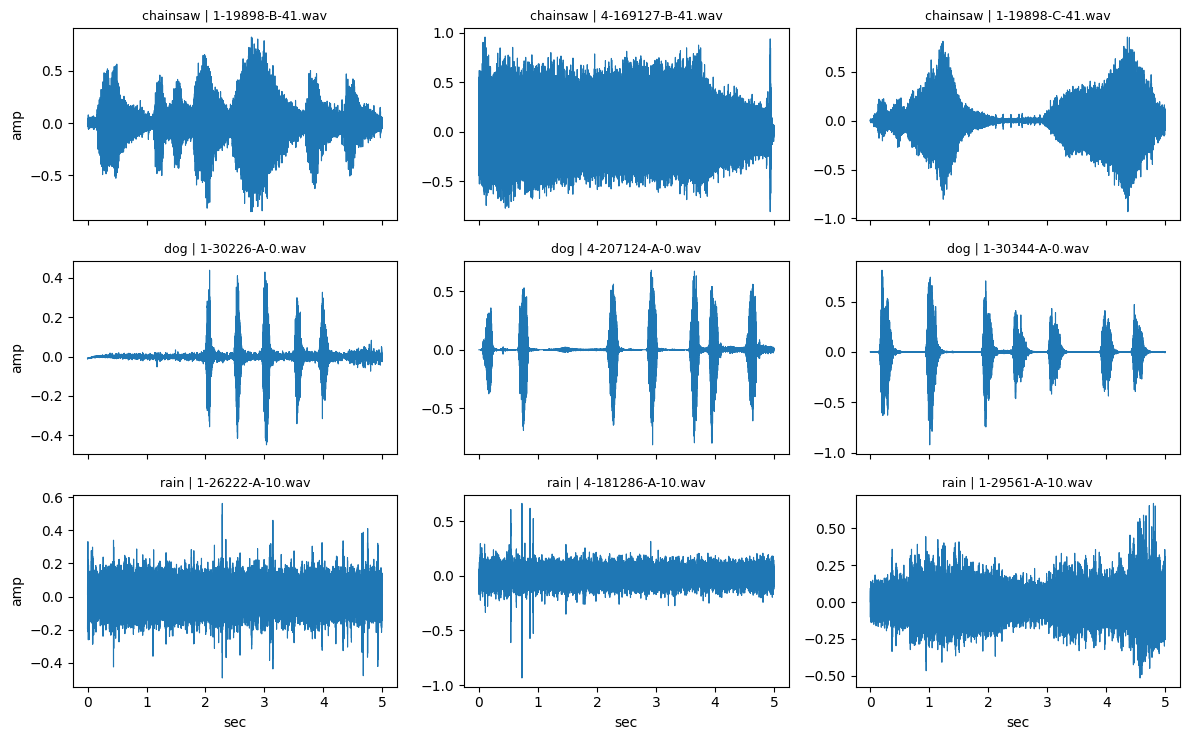

In [7]:
def plot_waveforms(df_sub: pd.DataFrame, n_per_label: int = 3, seed: int = 0):
    cats = sorted(df_sub["category"].unique())
    nrows = len(cats)
    ncols = n_per_label
    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 2.5*nrows), sharex=True, sharey=False)
    if nrows == 1:
        axes = np.array([axes])
    for r, cat in enumerate(cats):
        d = df_sub[df_sub["category"] == cat]
        picks = d.sample(n=min(n_per_label, len(d)), random_state=seed)["filename"].tolist()
        for c, fn in enumerate(picks):
            ax = axes[r, c] if ncols > 1 else axes[r, 0]
            x = load_preprocess(fn)
            t = np.arange(len(x)) / SAMPLE_RATE
            ax.plot(t, x, linewidth=0.8)
            ax.set_title(f"{cat} | {fn}", fontsize=9)
            if c == 0:
                ax.set_ylabel("amp")
            if r == nrows - 1:
                ax.set_xlabel("sec")
    plt.tight_layout()
    plt.show()

plot_waveforms(df_sel, n_per_label=3, seed=1)


## 6. 周波数スペクトル（FFT）を可視化

### 6.1 「平均±分散（標準偏差）」でラベル比較  
- ラベルごとに全サンプルを集めて FFT 振幅スペクトルを計算
- **周波数ごとの平均と標準偏差**を描画

### 6.2 生スペクトルの重ね描き  
- 統計だけだと分からない「個体差」を観察する


In [8]:
def magnitude_spectrum(x: np.ndarray, sr: int, n_fft: int = 4096, window: str = "hann") -> tuple[np.ndarray, np.ndarray]:
    """Return (freq [F], mag [F]) using rfft."""
    xt = torch.from_numpy(x).float()
    if window == "hann":
        w = torch.hann_window(n_fft)
    else:
        w = torch.ones(n_fft)
    if len(xt) < n_fft:
        xt = torch.nn.functional.pad(xt, (0, n_fft - len(xt)))
    else:
        xt = xt[:n_fft]
    X = torch.fft.rfft(xt * w)
    mag = (X.abs() + 1e-12).cpu().numpy()
    freq = np.fft.rfftfreq(n_fft, d=1.0/sr)
    return freq, mag

def compute_label_spectra(df_sub: pd.DataFrame, n_fft: int = 4096) -> tuple[np.ndarray, dict[str, np.ndarray]]:
    out = {}
    freq = None
    for cat in sorted(df_sub["category"].unique()):
        mags = []
        for fn in df_sub[df_sub["category"] == cat]["filename"].tolist():
            x = load_preprocess(fn)
            freq, mag = magnitude_spectrum(x, SAMPLE_RATE, n_fft=n_fft)
            mags.append(mag)
        out[cat] = np.stack(mags, axis=0)  # [N, F]
    assert freq is not None
    return freq, out

FREQ, spectra_by_cat = compute_label_spectra(df_sel, n_fft=4096)
print("freq bins:", len(FREQ), "cats:", list(spectra_by_cat.keys()))


freq bins: 2049 cats: ['chainsaw', 'dog', 'rain']


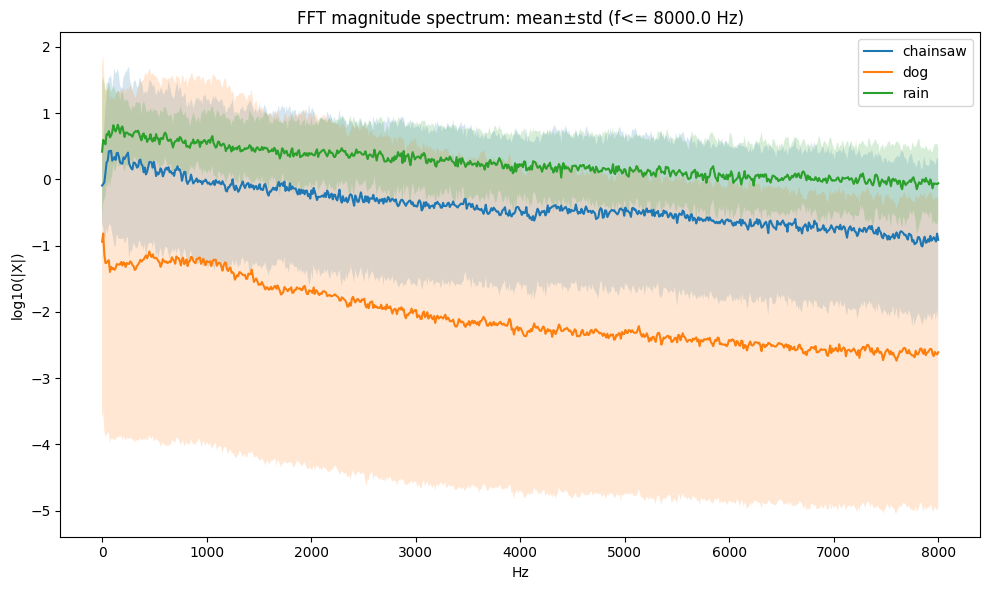

In [9]:
def plot_mean_std_spectrum(freq: np.ndarray, spectra: dict[str, np.ndarray], fmax: float = 8000.0, use_log: bool = True):
    plt.figure(figsize=(10, 6))
    mask = freq <= fmax
    for cat, M in spectra.items():
        X = np.log10(M + 1e-12) if use_log else M
        mu = X.mean(axis=0)
        sd = X.std(axis=0)
        plt.plot(freq[mask], mu[mask], label=f"{cat}")
        plt.fill_between(freq[mask], (mu - sd)[mask], (mu + sd)[mask], alpha=0.18)
    plt.title(f"FFT magnitude spectrum: mean±std (f<= {fmax} Hz)")
    plt.xlabel("Hz")
    plt.ylabel("log10(|X|)" if use_log else "|X|")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

plot_mean_std_spectrum(FREQ, spectra_by_cat, fmax=8000.0, use_log=True)


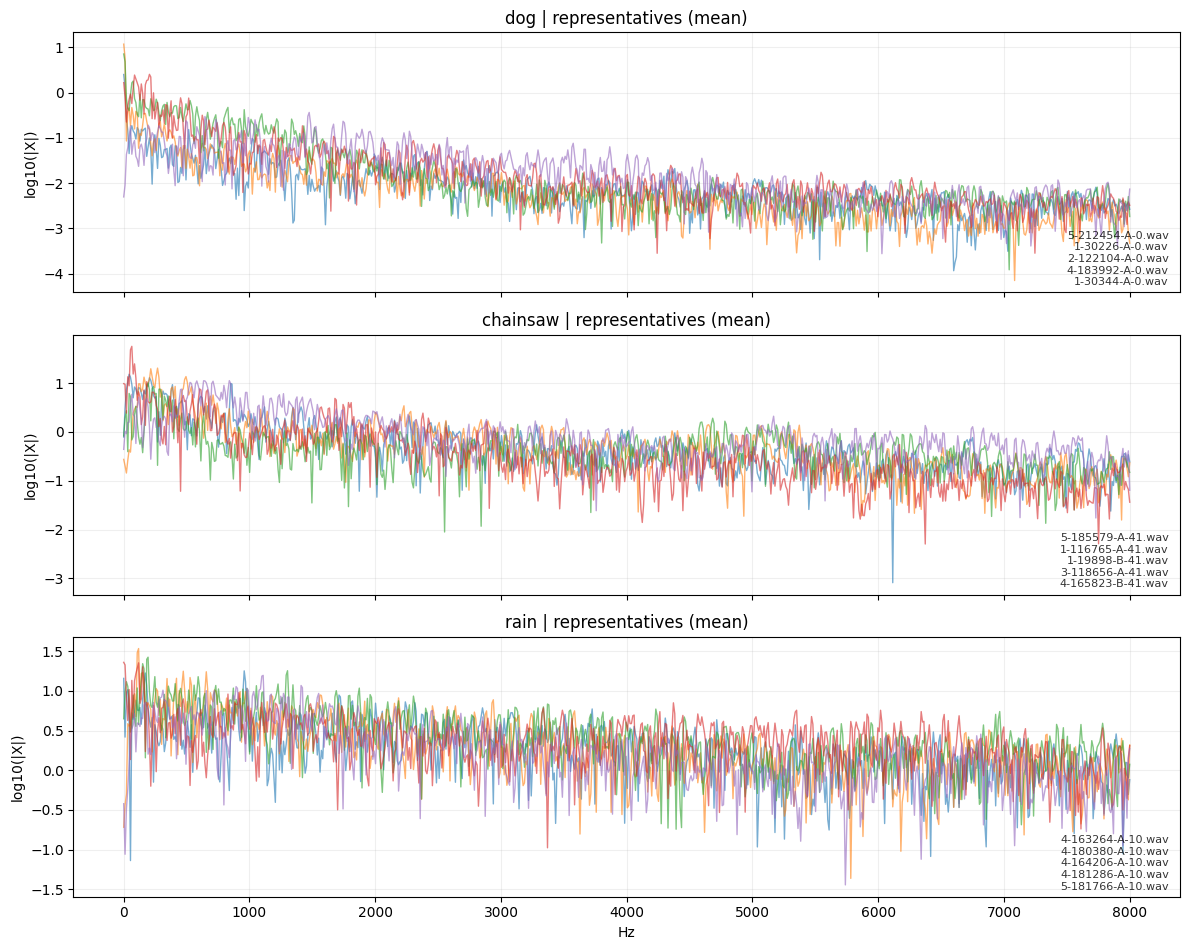

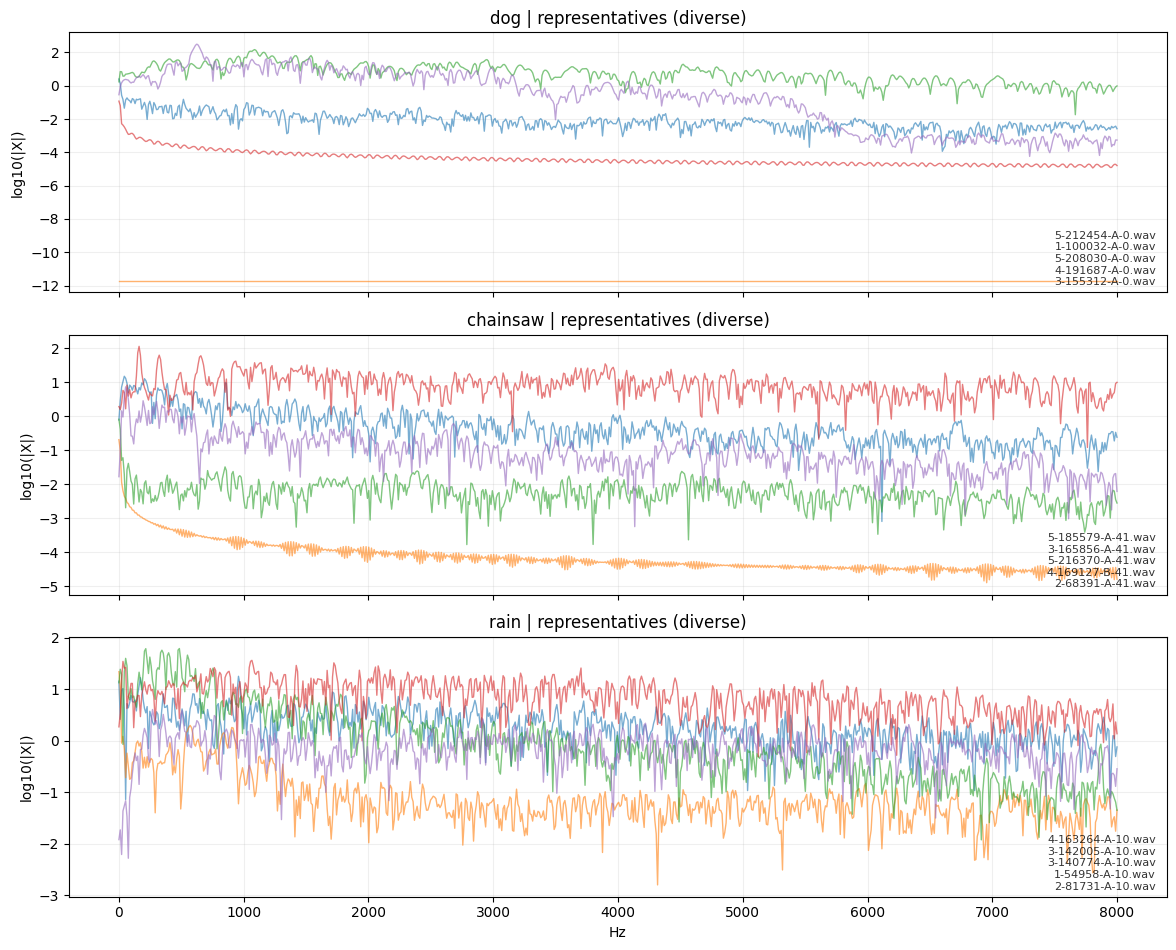

In [18]:
from typing import Dict, List, Tuple

def spectrum_feature(x: np.ndarray, sr: int, n_fft: int = 4096, fmax: float = 8000.0) -> Tuple[np.ndarray, np.ndarray]:
    """Return (freq<=fmax, log-mag)"""
    freq, mag = magnitude_spectrum(x, sr, n_fft=n_fft)
    mask = freq <= fmax
    feat = np.log10(mag[mask] + 1e-12)
    return freq[mask], feat

def pick_representatives_by_mean(df_sub: pd.DataFrame, cat: str, k: int = 5, n_fft: int = 4096, fmax: float = 8000.0) -> pd.DataFrame:
    """平均スペクトルに近い順で代表k個を選ぶ（プロトタイプ抽出）"""
    d = df_sub[df_sub["category"] == cat].copy()
    feats = []
    for fn in d["filename"].tolist():
        x = load_preprocess(fn)
        freq, feat = spectrum_feature(x, SAMPLE_RATE, n_fft=n_fft, fmax=fmax)
        feats.append(feat)
    X = np.stack(feats, axis=0)  # [N, F]
    mu = X.mean(axis=0, keepdims=True)
    dist = np.linalg.norm(X - mu, axis=1)  # L2 distance to mean spectrum
    d["dist_to_mean"] = dist
    return d.sort_values("dist_to_mean").head(k)

def pick_representatives_diverse(df_sub: pd.DataFrame, cat: str, k: int = 5, n_fft: int = 4096, fmax: float = 8000.0, seed: int = 0) -> pd.DataFrame:
    """
    多様性を保った代表k個：
    1) 平均に一番近い sample を medoid として選ぶ
    2) 残りは「既に選んだ集合から最も遠い」ものを順に追加（farthest-point sampling）
    """
    rng = np.random.default_rng(seed)
    d = df_sub[df_sub["category"] == cat].copy()
    feats = []
    for fn in d["filename"].tolist():
        x = load_preprocess(fn)
        _, feat = spectrum_feature(x, SAMPLE_RATE, n_fft=n_fft, fmax=fmax)
        feats.append(feat)
    X = np.stack(feats, axis=0)  # [N, F]

    mu = X.mean(axis=0, keepdims=True)
    d_to_mu = np.linalg.norm(X - mu, axis=1)
    first = int(np.argmin(d_to_mu))
    selected = [first]

    # precompute pairwise distances efficiently enough for ESC-50 (N<=40 per class)
    # dist(i,j) = ||X[i]-X[j]||
    # we compute on the fly to keep simple
    while len(selected) < min(k, X.shape[0]):
        # for each candidate, compute distance to nearest selected
        best_idx = None
        best_score = -1.0
        for i in range(X.shape[0]):
            if i in selected:
                continue
            nearest = min(np.linalg.norm(X[i] - X[j]) for j in selected)
            if nearest > best_score:
                best_score = nearest
                best_idx = i
        selected.append(int(best_idx))

    d = d.reset_index(drop=True)
    d["rep_rank"] = np.nan
    for r, idx in enumerate(selected):
        d.loc[idx, "rep_rank"] = r
    return d.dropna(subset=["rep_rank"]).sort_values("rep_rank")

def plot_representative_spectra(df_sub: pd.DataFrame, labels: List[str], mode: str = "mean", k: int = 5,
                                n_fft: int = 4096, fmax: float = 8000.0, seed: int = 0):
    """
    mode:
      - 'mean'   : 平均スペクトルに近い順
      - 'diverse': 多様性を保った代表
    """
    picks_by_label = {}
    for cat in labels:
        if mode == "mean":
            picks = pick_representatives_by_mean(df_sub, cat, k=k, n_fft=n_fft, fmax=fmax)
        elif mode == "diverse":
            picks = pick_representatives_diverse(df_sub, cat, k=k, n_fft=n_fft, fmax=fmax, seed=seed)
        else:
            raise ValueError("mode must be 'mean' or 'diverse'")
        picks_by_label[cat] = picks

    # --- plot: one panel per label, multiple lines per representative ---
    nrows = len(labels)
    fig, axes = plt.subplots(nrows, 1, figsize=(12, 3.2*nrows), sharex=True)
    if nrows == 1:
        axes = [axes]

    for ax, cat in zip(axes, labels):
        picks = picks_by_label[cat]
        for _, row in picks.iterrows():
            fn = row["filename"]
            x = load_preprocess(fn)
            freq, feat = spectrum_feature(x, SAMPLE_RATE, n_fft=n_fft, fmax=fmax)
            ax.plot(freq, feat, alpha=0.6, linewidth=1.0)
        ax.set_title(f"{cat} | representatives ({mode})")
        ax.set_ylabel("log10(|X|)")
        ax.grid(True, alpha=0.2)

        # show filenames as text (compact)
        shown = picks["filename"].tolist()
        ax.text(0.99, 0.02, "\n".join(shown), transform=ax.transAxes,
                ha="right", va="bottom", fontsize=8, alpha=0.8)

    axes[-1].set_xlabel("Hz")
    plt.tight_layout()
    plt.show()

# 実行例
plot_representative_spectra(df_sel, LABELS_TO_ANALYZE, mode="mean", k=5, fmax=8000.0)
plot_representative_spectra(df_sel, LABELS_TO_ANALYZE, mode="diverse", k=5, fmax=8000.0, seed=0)

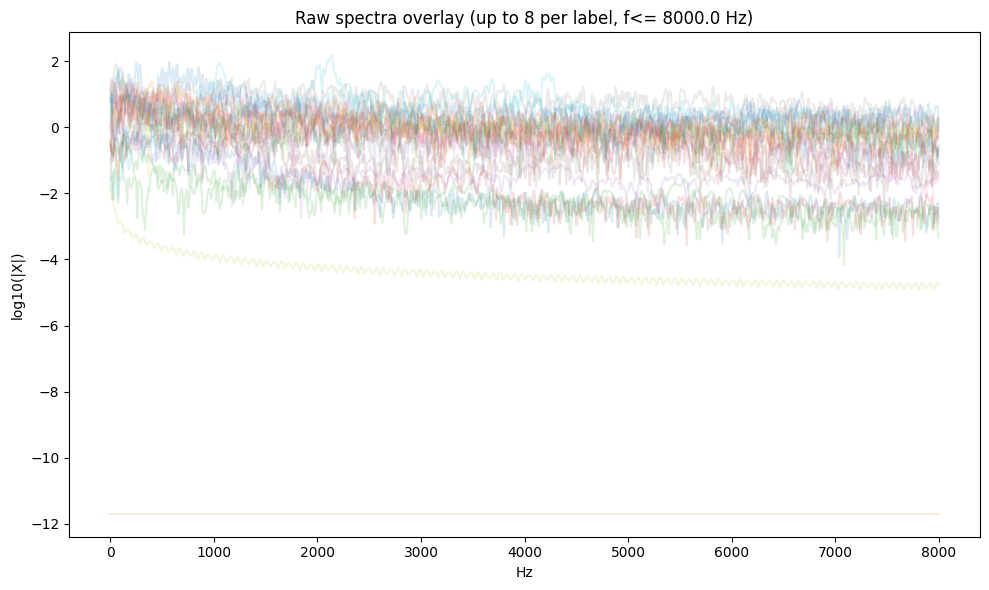

In [10]:
def plot_raw_spectra(freq: np.ndarray, df_sub: pd.DataFrame, n_per_label: int = 10, fmax: float = 8000.0, seed: int = 0):
    plt.figure(figsize=(10, 6))
    mask = freq <= fmax
    for cat in sorted(df_sub["category"].unique()):
        d = df_sub[df_sub["category"] == cat]
        picks = d.sample(n=min(n_per_label, len(d)), random_state=seed)["filename"].tolist()
        for fn in picks:
            x = load_preprocess(fn)
            fr, mag = magnitude_spectrum(x, SAMPLE_RATE, n_fft=4096)
            plt.plot(fr[mask], np.log10(mag[mask] + 1e-12), alpha=0.15)
    plt.title(f"Raw spectra overlay (up to {n_per_label} per label, f<= {fmax} Hz)")
    plt.xlabel("Hz")
    plt.ylabel("log10(|X|)")
    plt.tight_layout()
    plt.show()

plot_raw_spectra(FREQ, df_sel, n_per_label=8, fmax=8000.0, seed=2)


In [19]:
import numpy as np
import torch

def power_spectrum_periodogram(
    x: np.ndarray,
    sr: int,
    n_fft: int = 4096,
    window: str = "hann",
) -> tuple[np.ndarray, np.ndarray]:
    """
    one-sided power spectrum (periodogram-like), linear power.
    Returns:
      freq: [F]
      P:    [F]  (linear power, proportional to amplitude^2)
    Notes:
      - window normalization included so that scaling is less arbitrary.
      - For EDA / relative comparison between classes, this is usually enough.
    """
    xt = torch.from_numpy(x).float()
    if len(xt) < n_fft:
        xt = torch.nn.functional.pad(xt, (0, n_fft - len(xt)))
    else:
        xt = xt[:n_fft]

    if window == "hann":
        w = torch.hann_window(n_fft)
    else:
        w = torch.ones(n_fft)

    xw = xt * w
    X = torch.fft.rfft(xw)
    P = (X.abs() ** 2)

    # window power normalization (so energy doesn't depend on window choice too much)
    # This is a common normalization idea for periodogram-like features.
    w_power = (w**2).sum().clamp_min(1e-12)
    P = P / w_power

    freq = np.fft.rfftfreq(n_fft, d=1.0/sr)
    return freq, P.cpu().numpy()

def make_fractional_octave_bands(
    fmin: float,
    fmax: float,
    n: int = 3,
    f_ref: float = 1000.0,
) -> np.ndarray:
    """
    Create fractional-octave bands within [fmin, fmax].
    Returns array of (fc, flow, fhigh).
    """
    # find k range that covers fmin..fmax
    k_min = int(np.floor(n * np.log2(fmin / f_ref)))
    k_max = int(np.ceil (n * np.log2(fmax / f_ref)))

    bands = []
    for k in range(k_min, k_max + 1):
        fc = f_ref * (2 ** (k / n))
        flow = fc * (2 ** (-1 / (2*n)))
        fhigh = fc * (2 ** (+1 / (2*n)))
        if fhigh < fmin or flow > fmax:
            continue
        bands.append((fc, max(flow, fmin), min(fhigh, fmax)))
    return np.array(bands, dtype=np.float64)

def band_aggregate_power(
    freq: np.ndarray,
    P: np.ndarray,
    bands: np.ndarray,
    mode: str = "sum",
) -> np.ndarray:
    """
    Aggregate linear power P over each band.
    mode:
      - "sum": sum of power in band (energy-like)
      - "mean": mean power per bin in band (shape comparison)
    Returns:
      Pb: [B] linear
    """
    Pb = np.zeros(len(bands), dtype=np.float64)
    for i, (_fc, fl, fh) in enumerate(bands):
        mask = (freq >= fl) & (freq < fh)
        if not np.any(mask):
            Pb[i] = np.nan
            continue
        if mode == "sum":
            Pb[i] = float(np.sum(P[mask]))
        elif mode == "mean":
            Pb[i] = float(np.mean(P[mask]))
        else:
            raise ValueError("mode must be 'sum' or 'mean'")
    return Pb

def power_to_db(P: np.ndarray, ref: float = 1.0, eps: float = 1e-20) -> np.ndarray:
    """10log10 for power quantities."""
    return 10.0 * np.log10(np.maximum(P, eps) / ref)

# ===== 使用例（1サンプル）=====
# x = load_preprocess(filename)
# freq, P = power_spectrum_periodogram(x, SAMPLE_RATE, n_fft=4096)
# bands = make_fractional_octave_bands(fmin=20.0, fmax=8000.0, n=3)
# Pb = band_aggregate_power(freq, P, bands, mode="sum")
# Lb = power_to_db(Pb, ref=1.0)

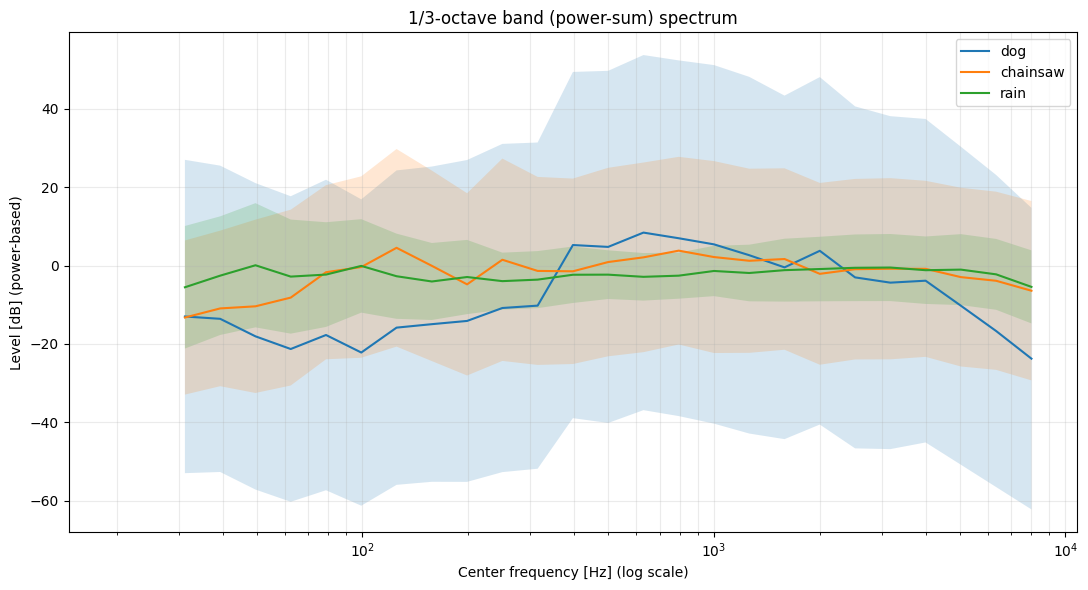

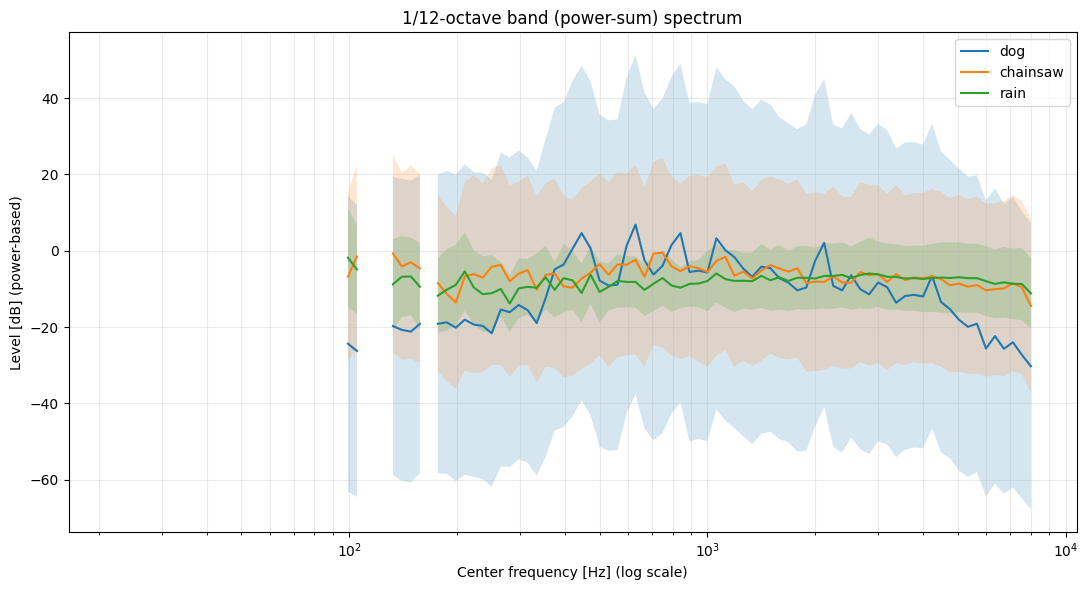

In [20]:
def compute_octaveband_db_by_label(
    df_sub: pd.DataFrame,
    labels: list[str],
    n: int = 3,              # 3 or 12
    fmin: float = 20.0,
    fmax: float = 8000.0,
    n_fft: int = 4096,
    agg_mode: str = "sum",   # "sum" 推奨（エネルギーとして合算）
) -> tuple[np.ndarray, dict[str, np.ndarray]]:
    """
    Returns:
      fcs: [B] center frequencies
      out: dict[label] -> L [N, B]  (dB values per sample)
    Important:
      - 代表値（平均）を作る時は dBで平均しない！
        → いったん線形(Pb)を平均してからdB化するのが基本。
      - ただし可視化として「個体差」を見たいなら L（dB）のstdも併記はOK（解釈に注意）。
    """
    # bands are shared across labels
    bands = make_fractional_octave_bands(fmin=fmin, fmax=fmax, n=n, f_ref=1000.0)
    fcs = bands[:, 0]

    out = {}
    for cat in labels:
        d = df_sub[df_sub["category"] == cat]
        L_list = []
        for fn in d["filename"].tolist():
            x = load_preprocess(fn)
            freq, P = power_spectrum_periodogram(x, SAMPLE_RATE, n_fft=n_fft)
            Pb = band_aggregate_power(freq, P, bands, mode=agg_mode)  # linear
            Lb = power_to_db(Pb)                                      # dB
            L_list.append(Lb)
        out[cat] = np.stack(L_list, axis=0)  # [N, B]
    return fcs, out

def plot_octaveband_stats(fcs: np.ndarray, L_by_cat: dict[str, np.ndarray], title: str = ""):
    """
    正しい平均：
      mean_dB = 10log10(mean(P_linear))
    ここでは L_by_cat はすでに dB ですが、平均は「線形に戻して平均」を取ります。
    """
    plt.figure(figsize=(11, 6))
    for cat, L in L_by_cat.items():
        # dB -> linear power
        P_lin = 10 ** (L / 10.0)

        mean_lin = P_lin.mean(axis=0)
        mean_db = 10 * np.log10(np.maximum(mean_lin, 1e-20))

        # 個体差の可視化として、各サンプルをdBにした後のstdを薄く表示（参考）
        std_db = L.std(axis=0)

        plt.semilogx(fcs, mean_db, label=cat)
        plt.fill_between(fcs, mean_db - std_db, mean_db + std_db, alpha=0.18)

    plt.title(title or "Fractional-octave band spectrum (mean±std) [dB]")
    plt.xlabel("Center frequency [Hz] (log scale)")
    plt.ylabel("Level [dB] (power-based)")
    plt.grid(True, which="both", alpha=0.25)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 実行例：
fcs, L_by = compute_octaveband_db_by_label(df_sel, LABELS_TO_ANALYZE, n=3, fmax=8000.0)
plot_octaveband_stats(fcs, L_by, title="1/3-octave band (power-sum) spectrum")

fcs, L_by = compute_octaveband_db_by_label(df_sel, LABELS_TO_ANALYZE, n=12, fmax=8000.0)
plot_octaveband_stats(fcs, L_by, title="1/12-octave band (power-sum) spectrum")

## 7. スペクトログラム（STFT）を可視化

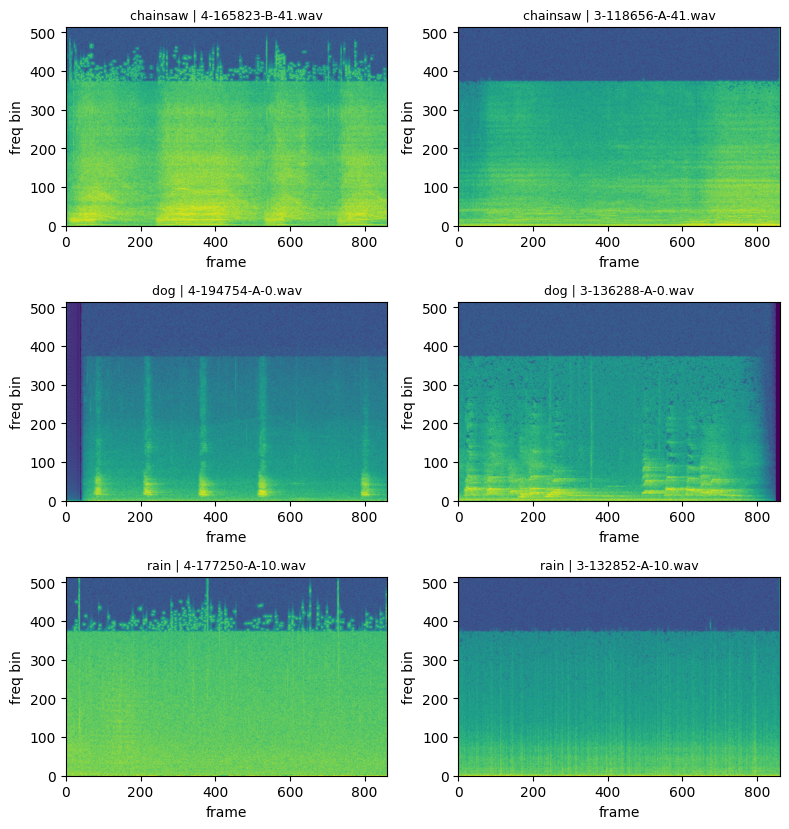

In [11]:
def stft_spectrogram(x: np.ndarray, n_fft: int = 1024, hop: int = 256, win: int | None = None) -> np.ndarray:
    win = win or n_fft
    xt = torch.from_numpy(x).float()
    w = torch.hann_window(win)
    S = torch.stft(xt, n_fft=n_fft, hop_length=hop, win_length=win, window=w, return_complex=True)
    P = (S.abs() ** 2).cpu().numpy()  # [F, T]
    return P

def plot_spectrograms(df_sub: pd.DataFrame, n_per_label: int = 3, n_fft: int = 1024, hop: int = 256, seed: int = 0):
    cats = sorted(df_sub["category"].unique())
    fig, axes = plt.subplots(len(cats), n_per_label, figsize=(4*n_per_label, 2.8*len(cats)))
    if len(cats) == 1:
        axes = np.array([axes])
    for r, cat in enumerate(cats):
        d = df_sub[df_sub["category"] == cat]
        picks = d.sample(n=min(n_per_label, len(d)), random_state=seed)["filename"].tolist()
        for c, fn in enumerate(picks):
            x = load_preprocess(fn)
            P = stft_spectrogram(x, n_fft=n_fft, hop=hop)
            PdB = 10.0 * np.log10(P + 1e-12)
            ax = axes[r, c] if n_per_label > 1 else axes[r, 0]
            ax.imshow(PdB, origin="lower", aspect="auto")
            ax.set_title(f"{cat} | {fn}", fontsize=9)
            ax.set_xlabel("frame")
            ax.set_ylabel("freq bin")
    plt.tight_layout()
    plt.show()

plot_spectrograms(df_sel, n_per_label=2, n_fft=1024, hop=256, seed=3)


## 8. Log-Mel（モデルに入れている特徴）を可視化

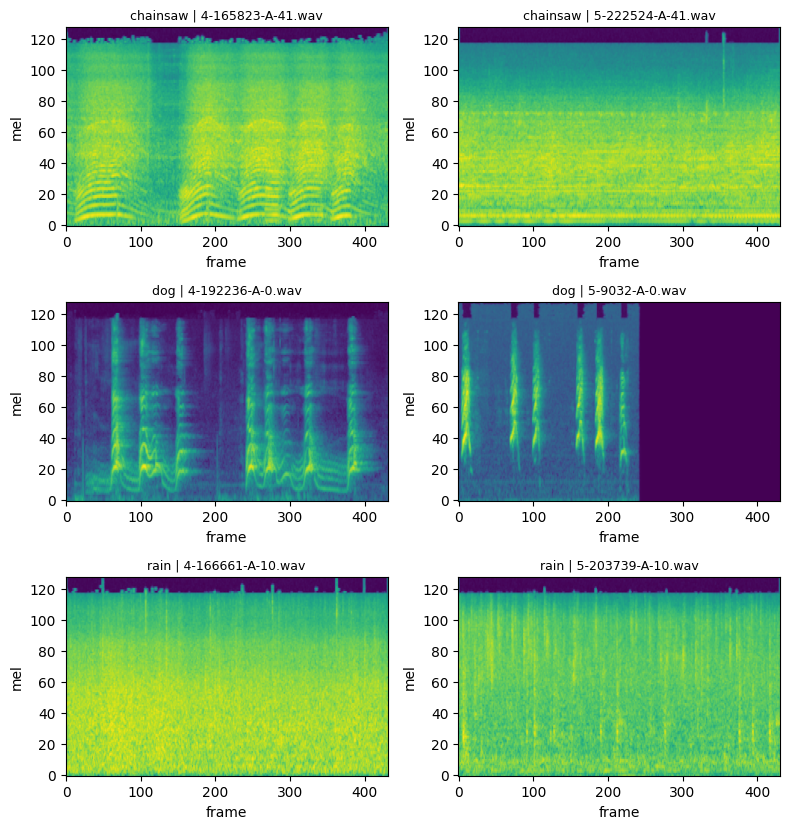

In [12]:
feat_cfg = FeatureConfig(
    sample_rate=int(a.get("sample_rate", 44100)),
    duration_sec=float(a.get("duration_sec", 5.0)),
    n_fft=int(f.get("n_fft", 2048)),
    hop_length=int(f.get("hop_length", 512)),
    win_length=int(f.get("win_length", 2048)),
    n_mels=int(f.get("n_mels", 128)),
    f_min=float(f.get("f_min", 0.0)),
    f_max=None if f.get("f_max") in (None, "null") else float(f.get("f_max")),
    log_eps=float(f.get("log_eps", 1e-6)),
    normalize=str(f.get("normalize", "per_sample")),
)
extractor = LogMelExtractor(feat_cfg)

def logmel_from_wav(x: np.ndarray) -> np.ndarray:
    xt = torch.from_numpy(x).float().unsqueeze(0)  # [1, T]
    feat = extractor(xt)
    if isinstance(feat, torch.Tensor):
        feat = feat.detach().cpu().numpy()
    return feat

def plot_logmel(df_sub: pd.DataFrame, n_per_label: int = 3, seed: int = 0):
    cats = sorted(df_sub["category"].unique())
    fig, axes = plt.subplots(len(cats), n_per_label, figsize=(4*n_per_label, 2.8*len(cats)))
    if len(cats) == 1:
        axes = np.array([axes])
    for r, cat in enumerate(cats):
        d = df_sub[df_sub["category"] == cat]
        picks = d.sample(n=min(n_per_label, len(d)), random_state=seed)["filename"].tolist()
        for c, fn in enumerate(picks):
            x = load_preprocess(fn)
            feat = logmel_from_wav(x)
            feat2 = feat[0] if feat.ndim == 3 else feat
            ax = axes[r, c] if n_per_label > 1 else axes[r, 0]
            ax.imshow(feat2, origin="lower", aspect="auto")
            ax.set_title(f"{cat} | {fn}", fontsize=9)
            ax.set_xlabel("frame")
            ax.set_ylabel("mel")
    plt.tight_layout()
    plt.show()

plot_logmel(df_sel, n_per_label=2, seed=4)


### 全wav→Log-Mel→1本の固定長ベクトルに要約→UMAP→散布図（離散カラーマップ）

- ラベルが混ざっている領域：この特徴（Log-Mel要約）だけでは分離が難しい可能性 → モデルも混乱しやすい（誤分類が多い組）
- 1つのラベルが複数の塊に分かれる：そのラベルが多モード（音の型が複数）→ クラス内ばらつきが大きく、学習が難しい
- 疎な領域にいる点：外れ値・録音条件が違う・ラベル誤り候補 → データ品質チェックの入口

In [21]:
import numpy as np
import pandas as pd
import torch

def logmel_image(x: np.ndarray) -> np.ndarray:
    """Return log-mel image as numpy [n_mels, frames]"""
    xt = torch.from_numpy(x).float().unsqueeze(0)  # [1, T]
    feat = extractor(xt)
    if isinstance(feat, torch.Tensor):
        feat = feat.detach().cpu().numpy()
    # feat: [1, n_mels, frames] or [n_mels, frames]
    feat = feat[0] if feat.ndim == 3 else feat
    return feat

def summarize_logmel(feat2d: np.ndarray, mode: str = "meanstd") -> np.ndarray:
    """
    Convert [n_mels, frames] -> 1D vector.
    mode:
      - "mean": mel-wise mean only  -> [n_mels]
      - "meanstd": mel-wise mean+std -> [2*n_mels] (recommended)
      - "stats": mean,std,min,max -> [4*n_mels] (heavier)
    """
    m = feat2d.mean(axis=1)
    if mode == "mean":
        return m
    s = feat2d.std(axis=1)
    if mode == "meanstd":
        return np.concatenate([m, s], axis=0)
    mn = feat2d.min(axis=1)
    mx = feat2d.max(axis=1)
    return np.concatenate([m, s, mn, mx], axis=0)

def build_logmel_embedding_df(df_in: pd.DataFrame, mode: str = "meanstd") -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Returns:
      X: [N, D] float32
      y: [N] int
      filenames: [N] str
    """
    feats = []
    ys = []
    fns = []
    for _, r in df_in.iterrows():
        fn = r["filename"]
        y = int(r["target"])
        x = load_preprocess(fn)
        feat2d = logmel_image(x)
        v = summarize_logmel(feat2d, mode=mode)
        feats.append(v.astype(np.float32))
        ys.append(y)
        fns.append(fn)
    X = np.stack(feats, axis=0)
    y = np.array(ys, dtype=np.int64)
    fns = np.array(fns, dtype=object)
    return X, y, fns

# 全データでやる
df_all = df.copy()

X, y, filenames = build_logmel_embedding_df(df_all, mode="meanstd")
print("X:", X.shape, "num_classes:", len(np.unique(y)))

X: (2000, 256) num_classes: 50


In [22]:
from sklearn.preprocessing import StandardScaler
import umap

# UMAP前の標準化（大事：距離が次元スケールに支配されるのを防ぐ）
Xn = StandardScaler().fit_transform(X)

reducer = umap.UMAP(
    n_neighbors=30,
    min_dist=0.1,
    metric="euclidean",
    random_state=int(cfg["project"]["seed"]),
)
Z = reducer.fit_transform(Xn)  # [N, 2]
Z.shape

c:\Users\hirok\venv\py312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\hirok\venv\py312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(2000, 2)

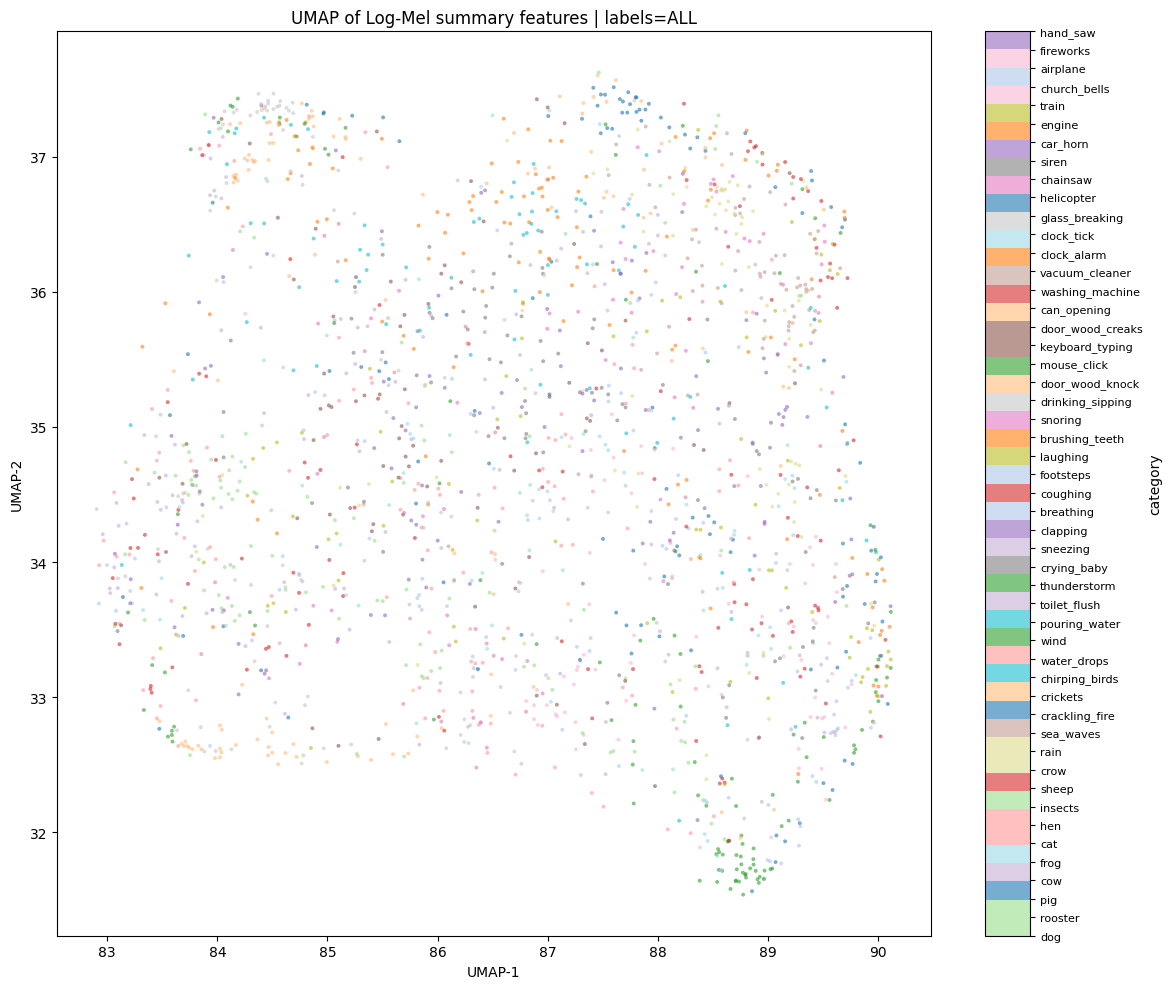

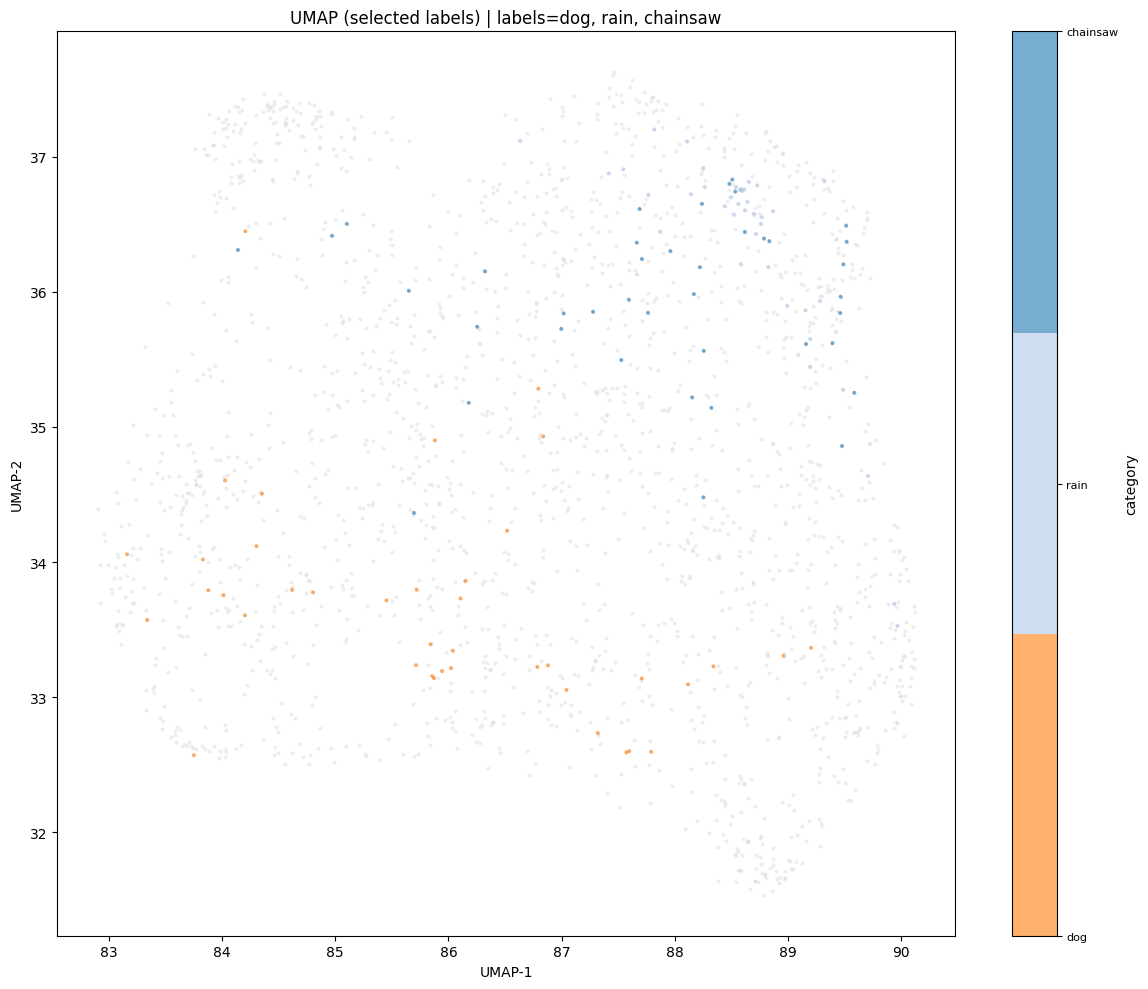

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

def plot_umap_by_labels(
    Z: np.ndarray,
    y: np.ndarray,
    df_meta: pd.DataFrame,
    *,
    labels: list[str] | None = None,     # None -> 全ラベル
    emphasize: bool = True,              # True: 全点グレー + 選択ラベルだけ色
    point_size: int = 8,
    alpha_all: float = 0.4,
    alpha_sel: float = 0.6,
    seed: int = 0,
    title: str = "UMAP",
):
    """
    Z: [N,2], y: [N] target id, df_meta: ESC-50 metadata (target/category mapping用)
    labels: category名のリスト（例: ["dog","rain"]）。Noneなら全表示。
    emphasize:
      - True: 全点を薄いグレーで描き、選択ラベルだけ色で強調（おすすめ）
      - False: 選択ラベルだけ描く
    """
    # target->category, category->target
    t2c = df_meta.sort_values("target").drop_duplicates("target").set_index("target")["category"].to_dict()
    c2t = {c: int(t) for t, c in t2c.items()}
    num_classes = int(df_meta["target"].nunique())

    # 表示対象の target を決める
    if labels is None:
        sel_targets = np.arange(num_classes, dtype=int)
        labels_txt = "ALL"
    else:
        missing = [c for c in labels if c not in c2t]
        if missing:
            raise ValueError(f"Unknown category in labels: {missing}")
        sel_targets = np.array([c2t[c] for c in labels], dtype=int)
        labels_txt = ", ".join(labels)

    sel_mask = np.isin(y, sel_targets)

    # 選択対象に対してだけ離散カラーマップを作る（見やすい）
    # （全体表示のときは全50クラス）
    K = len(sel_targets)
    base = plt.get_cmap("tab20").colors
    colors = (list(base) * ((K // len(base)) + 1))[:K]
    rng = np.random.default_rng(seed)
    perm = rng.permutation(K)
    colors = [colors[i] for i in perm]
    cmap = mpl.colors.ListedColormap(colors)

    # target id -> 0..K-1 に詰め直す（カラーマップ用）
    target_to_index = {int(t): i for i, t in enumerate(sel_targets.tolist())}
    c_sel = np.array([target_to_index[int(t)] for t in y[sel_mask]], dtype=int)

    plt.figure(figsize=(12, 10))

    if emphasize and labels is not None:
        # 全点グレー
        plt.scatter(Z[:, 0], Z[:, 1], c="lightgray", s=point_size, alpha=alpha_all, linewidths=0)

    # 選択ラベル点
    Z_sel = Z[sel_mask]
    sc = plt.scatter(Z_sel[:, 0], Z_sel[:, 1], c=c_sel, s=point_size, alpha=alpha_sel, cmap=cmap, linewidths=0)

    # 離散カラーバー（選択ラベルだけ表示）
    ticks = np.arange(K)
    cb = plt.colorbar(sc, ticks=ticks)
    ticklabels = [t2c[int(t)] for t in sel_targets]
    cb.ax.set_yticklabels(ticklabels)
    cb.set_label("category")
    cb.ax.tick_params(labelsize=8)

    plt.title(f"{title} | labels={labels_txt}")
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.tight_layout()
    plt.show()


# --- 使い方 ---
# 全ラベル（50クラス）
plot_umap_by_labels(Z, y, df, labels=None, seed=int(cfg["project"]["seed"]), title="UMAP of Log-Mel summary features")

# 指定ラベルだけ（全点グレー+選択だけ強調）
plot_umap_by_labels(Z, y, df, labels=["dog", "rain", "chainsaw"], emphasize=True, seed=int(cfg["project"]["seed"]), title="UMAP (selected labels)")

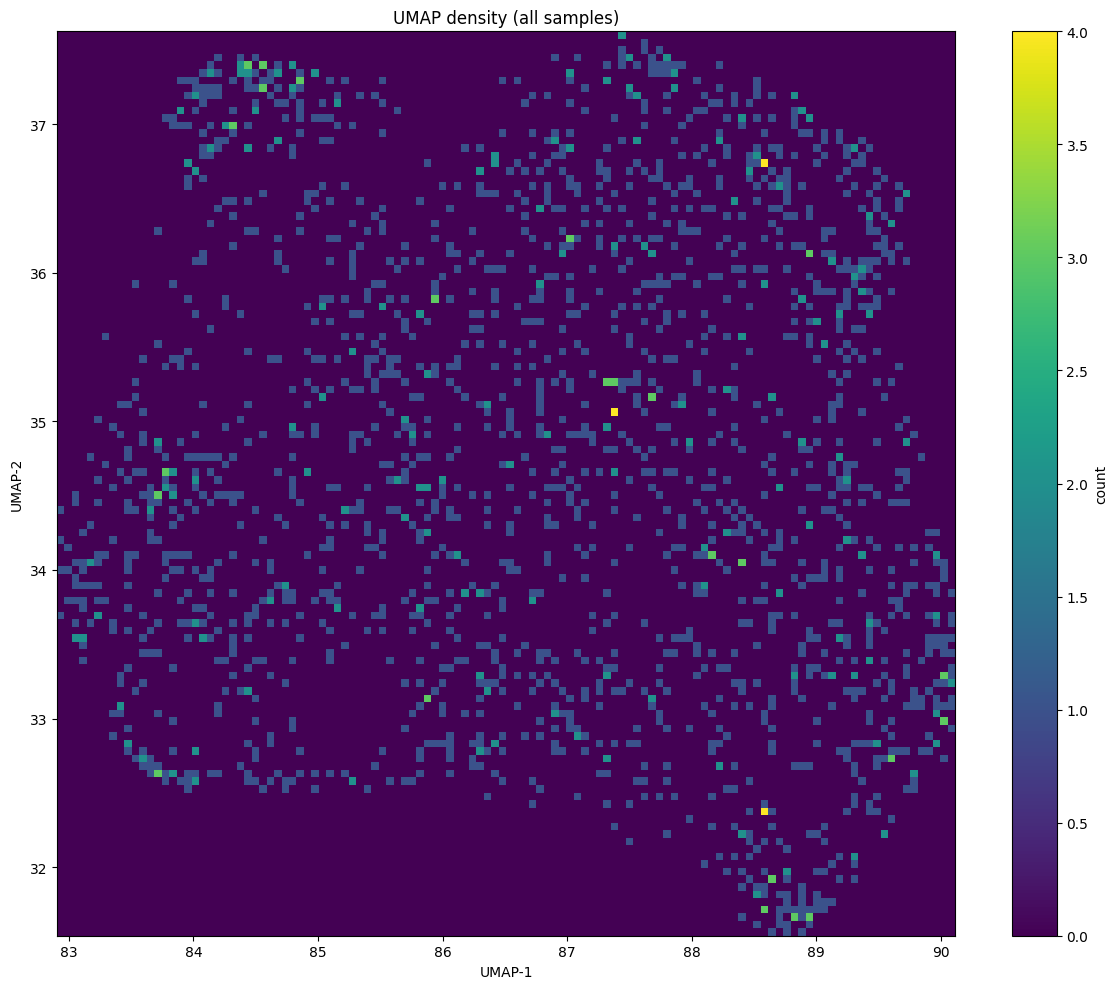

In [24]:
# 2Dヒストグラム密度（KDEより軽い）
plt.figure(figsize=(12, 10))
plt.hist2d(Z[:, 0], Z[:, 1], bins=120)
plt.colorbar(label="count")
plt.title("UMAP density (all samples)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.tight_layout()
plt.show()

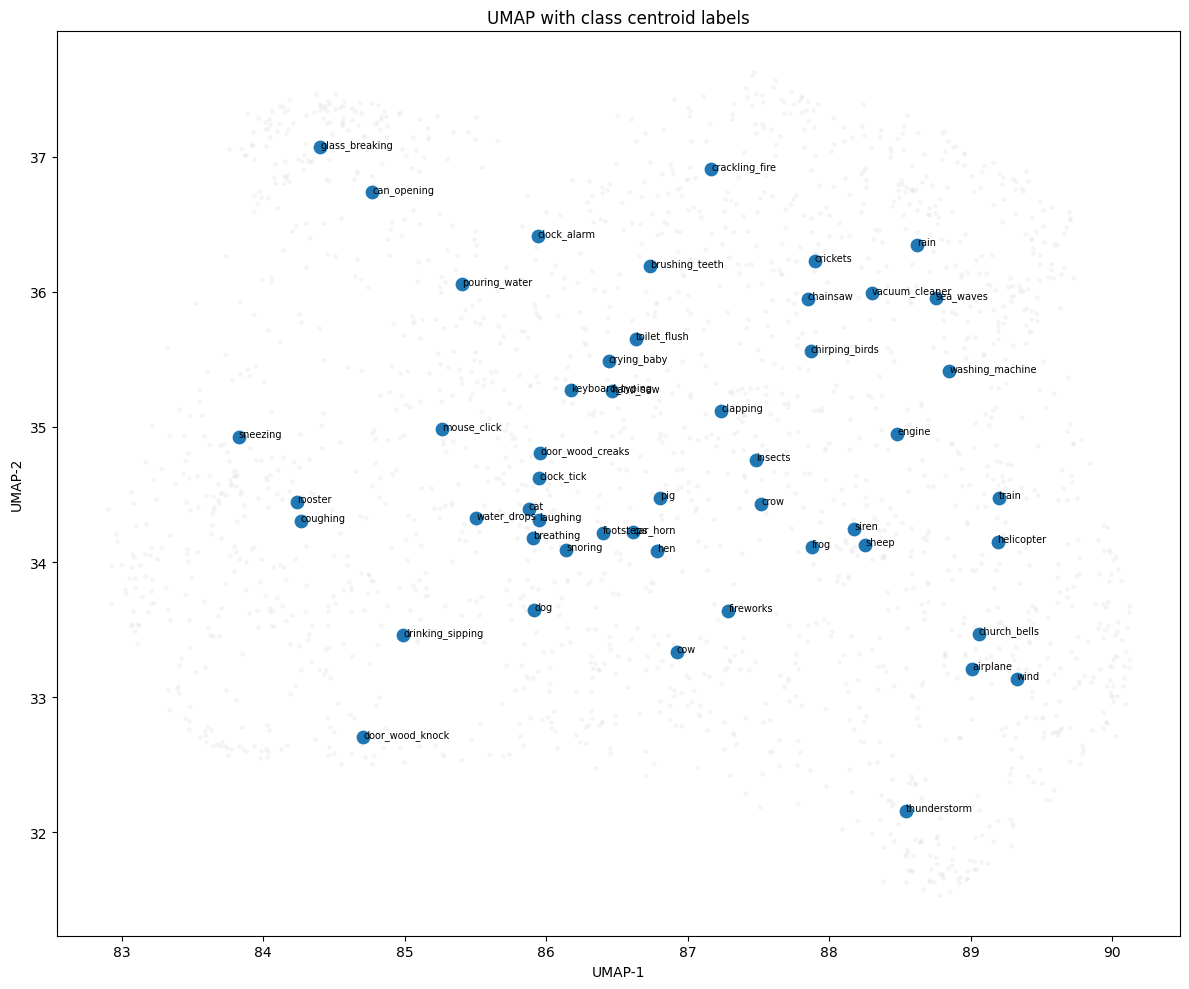

In [ ]:
# クラス重心
centroids = []
for t in sorted(np.unique(y)):
    mask = (y == t)
    c = Z[mask].mean(axis=0)
    centroids.append((t, c))
centroids = sorted(centroids, key=lambda x: x[0])

target_to_cat = df.sort_values("target").drop_duplicates("target").set_index("target")["category"].to_dict()

C = np.stack([c for _, c in centroids], axis=0)  # [K, 2]

plt.figure(figsize=(12, 10))
plt.scatter(Z[:, 0], Z[:, 1], c="lightgray", s=6, alpha=0.15)
plt.scatter(C[:, 0], C[:, 1], s=80)

for (t, c) in centroids:
    plt.text(c[0], c[1], target_to_cat.get(int(t), str(t)), fontsize=7)

plt.title("UMAP with class centroid labels")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.tight_layout()
plt.show()

In [26]:
from scipy.spatial.distance import cdist

D = cdist(C, C)  # centroid distances
K = D.shape[0]

# 各クラスに対して近いクラスTop5
rows = []
for i, (t, _) in enumerate(centroids):
    order = np.argsort(D[i])
    near = [int(centroids[j][0]) for j in order[1:6]]
    rows.append({
        "target": int(t),
        "category": target_to_cat.get(int(t), str(t)),
        "nearest_1": target_to_cat.get(near[0], str(near[0])),
        "nearest_2": target_to_cat.get(near[1], str(near[1])),
        "nearest_3": target_to_cat.get(near[2], str(near[2])),
        "nearest_4": target_to_cat.get(near[3], str(near[3])),
        "nearest_5": target_to_cat.get(near[4], str(near[4])),
    })

pd.DataFrame(rows).head(10)

target category  nearest_1  nearest_2    nearest_3         nearest_4  \
0       0      dog    snoring  breathing     laughing               cat   
1       1  rooster   coughing   sneezing  mouse_click  drinking_sipping   
2       2      pig   car_horn        hen    footsteps              crow   
3       3      cow  fireworks        hen     car_horn         footsteps   
4       4     frog      siren      sheep         crow           insects   
5       5      cat   laughing  breathing   clock_tick       water_drops   
6       6      hen   car_horn        pig    footsteps           snoring   
7       7  insects       crow   clapping          pig              frog   
8       8    sheep      siren       frog         crow            engine   
9       9     crow    insects       frog        siren               pig   

     nearest_5  
0    footsteps  
1  water_drops  
2      insects  
3          dog  
4    fireworks  
5      snoring  
6    fireworks  
7        siren  
8   helicopter  
9     clapping

## 9. 古典的な簡易特徴量の分布比較（RMS/ZCR/スペクトル統計）

In [15]:
def rms(x: np.ndarray) -> float:
    return float(np.sqrt(np.mean(x**2) + 1e-12))

def zcr(x: np.ndarray) -> float:
    s = np.sign(x)
    return float(np.mean(s[1:] != s[:-1]))

def spectral_features(x: np.ndarray, sr: int, n_fft: int = 4096) -> dict[str, float]:
    freq, mag = magnitude_spectrum(x, sr, n_fft=n_fft)

    # power spectrum
    p = mag**2
    s = p.sum()

    # 無音・極小エネルギー対策
    if not np.isfinite(s) or s <= 1e-20:
        return {"centroid_hz": 0.0, "bandwidth_hz": 0.0, "rolloff85_hz": 0.0}

    p = p / s

    centroid = float((freq * p).sum())
    bandwidth = float(np.sqrt(((freq - centroid) ** 2 * p).sum()))

    cdf = np.cumsum(p)

    # 浮動小数誤差などで cdf[-1] < 1 になる場合に備えて再正規化
    if cdf[-1] > 0:
        cdf = cdf / cdf[-1]

    idx = int(np.searchsorted(cdf, 0.85, side="left"))
    idx = int(np.clip(idx, 0, len(freq) - 1))  # ★ここが重要

    rolloff = float(freq[idx])

    return {"centroid_hz": centroid, "bandwidth_hz": bandwidth, "rolloff85_hz": rolloff}

rows = []
for _, r in df_sel.iterrows():
    fn = r["filename"]
    cat = r["category"]
    x = load_preprocess(fn)
    feats = {"filename": fn, "category": cat, "rms": rms(x), "zcr": zcr(x)}
    feats.update(spectral_features(x, SAMPLE_RATE))
    rows.append(feats)

df_feat = pd.DataFrame(rows)
df_feat.head()


filename  category       rms       zcr  centroid_hz  bandwidth_hz  \
0   1-100032-A-0.wav       dog  0.041525  0.009052     0.000000      0.000000   
1   1-110389-A-0.wav       dog  0.034617  0.002458  1011.914089    592.965877   
2  1-116765-A-41.wav  chainsaw  0.173532  0.052876   525.814522    868.925366   
3   1-17367-A-10.wav      rain  0.087673  0.136549  1469.740555   1840.452979   
4   1-19898-A-41.wav  chainsaw  0.064817  0.077175   274.342147   1082.671500   

   rolloff85_hz  
0      0.000000  
1   1679.589844  
2    538.330078  
3   3326.879883  
4     96.899414

In [16]:
summary = df_feat.groupby("category")[["rms","zcr","centroid_hz","bandwidth_hz","rolloff85_hz"]].agg(["mean","std","min","max"])
summary


rms                                     zcr            \
              mean       std       min       max      mean       std   
category                                                               
chainsaw  0.160189  0.057729  0.026964  0.296071  0.092948  0.044277   
dog       0.109792  0.070540  0.020479  0.338713  0.040938  0.025272   
rain      0.088429  0.039001  0.023064  0.188149  0.150145  0.072680   

                              centroid_hz                          \
               min       max         mean          std        min   
category                                                            
chainsaw  0.032277  0.185742  1057.537591   780.323902   2.599395   
dog       0.002458  0.112227   555.826544   534.491845   0.000000   
rain      0.010943  0.335494  2301.955429  1679.583111  85.383096   

                      bandwidth_hz                                        \
                  max         mean          std         min          max   
category                                                                   
chainsaw  2743.690522  1532.683329   903.016386   47.447050  3421.615837   
dog       2115.810031   662.895361   545.976717    0.000000  2512.028159   
rain      7639.054213  2403.653721  1094.053807  368.460314  4515.053974   

         rolloff85_hz                                        
                 mean          std        min           max  
category                                                     
chainsaw  1931.259155  1911.373191  10.766602   6535.327148  
dog        720.554810   701.097381   0.000000   2508.618164  
rain      4414.844971  3180.414224  10.766602  11800.195312

C:\Users\hirok\AppData\Local\Temp\ipykernel_6280\2250919432.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=cats, showfliers=False)


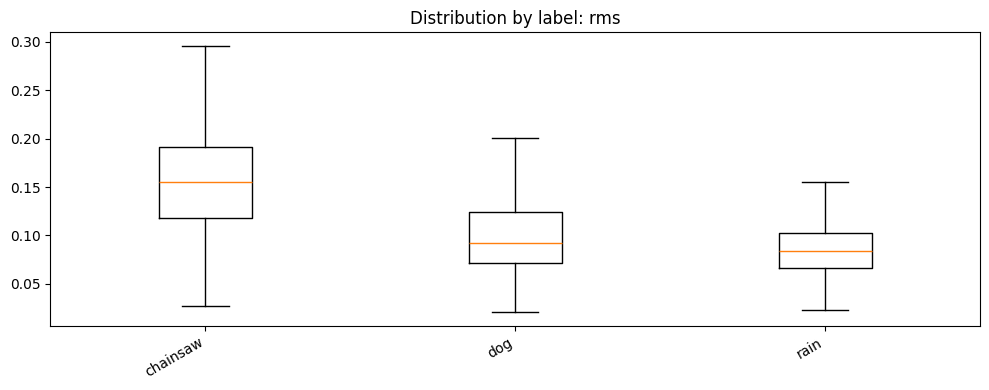

C:\Users\hirok\AppData\Local\Temp\ipykernel_6280\2250919432.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=cats, showfliers=False)


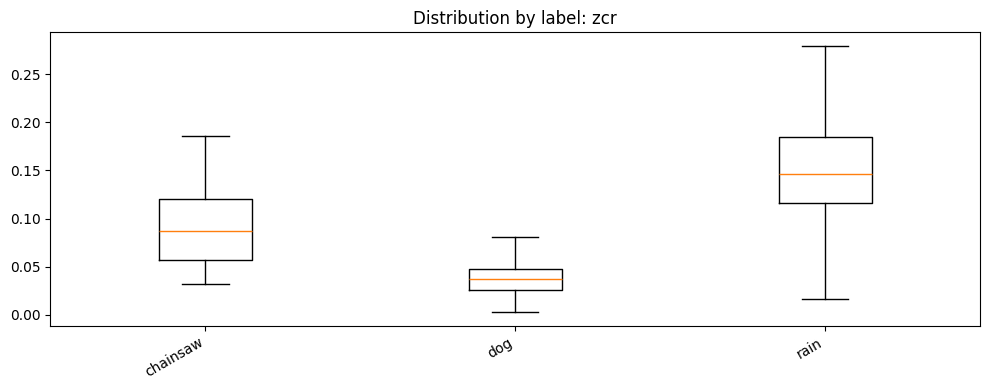

C:\Users\hirok\AppData\Local\Temp\ipykernel_6280\2250919432.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=cats, showfliers=False)


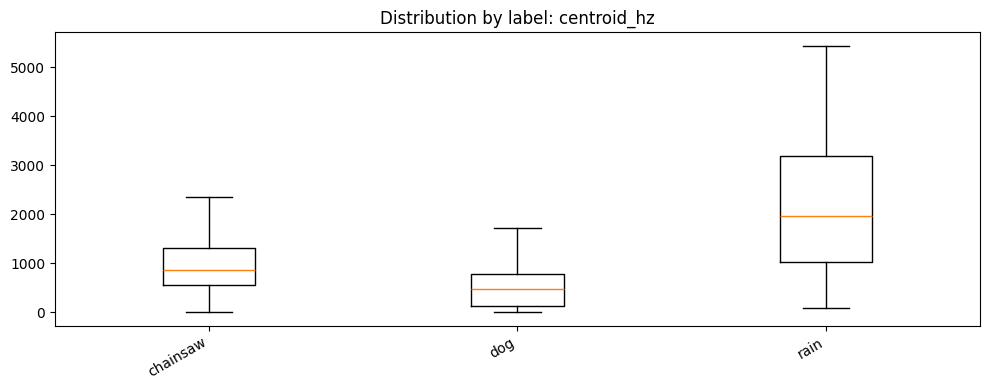

C:\Users\hirok\AppData\Local\Temp\ipykernel_6280\2250919432.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=cats, showfliers=False)


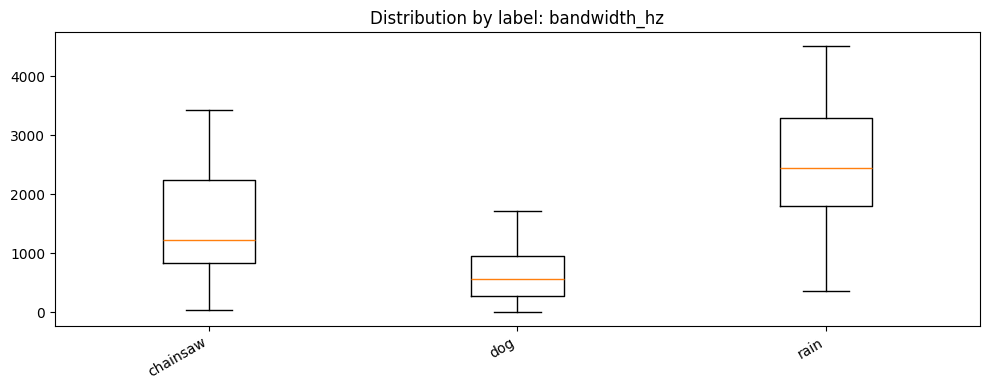

C:\Users\hirok\AppData\Local\Temp\ipykernel_6280\2250919432.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=cats, showfliers=False)


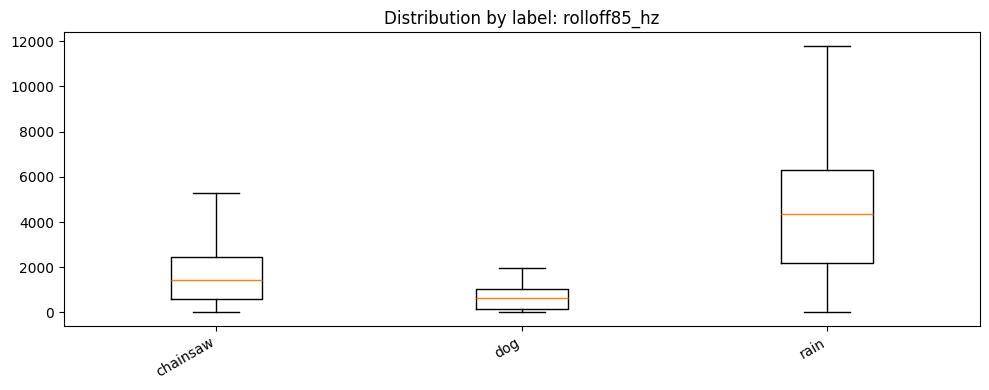

In [17]:
metrics = ["rms","zcr","centroid_hz","bandwidth_hz","rolloff85_hz"]

for m in metrics:
    cats = sorted(df_feat["category"].unique())
    data = [df_feat[df_feat["category"]==c][m].values for c in cats]
    plt.figure(figsize=(10, 4))
    plt.boxplot(data, labels=cats, showfliers=False)
    plt.title(f"Distribution by label: {m}")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()


## 10. 次の一手
- LABELS_TO_ANALYZE を増やして、似たカテゴリ同士の比較をする  
- 誤分類が多いクラス同士をこのEDAで比較し、「上流特徴で分かれていない」理由を探る  
- 気づいた前処理（帯域制限、正規化、前後カット等）を config に反映して再学習  
